In [2]:
import sys, os
import xarray as xr
import numpy as np
import h5py

from ulmo.plotting import plotting

## dineof rmse

In [ ]:
# rmse
def rmse_DINEOF(p):
    # open files
    ds_orig = xr.open_dataset('Enki_LLC_orig.nc')
    ds_recon = xr.open_dataset('Enki_LLC_DINEOF_p{}.nc'.format(p))
    mask_file = 'mae_mask_t75_p10.h5'
    f_ma = h5py.File(mask_file, 'r')
    
    # extract data
    orig_imgs = np.asarray(ds_orig.variables['SST'])
    recon_imgs = np.asarray(ds_recon.variables['sst_filled'])
    mask_imgs = []
    for i in range(180):
        mask_imgs.append(f_ma['valid'][i,0,...])
        
    print('calculate')
    calc = (recon_imgs - orig_imgs)*mask_imgs
    calc = calc**2
    nmask = np.sum(mask_imgs, axis=(1,2))
    calc = np.sum(calc, axis=(1,2)) / nmask
    rmse = np.sqrt(calc)
    
    return rmse


In [ ]:
# do 
mask_p = [10,20,30,40,50]
for p in mask_p:
    rmse = rmse_DINEOF(p)

## creating the cloudy dineof files

In [ ]:
ds_orig = xr.open_dataset("Enki_LLC_orig.nc")
for p in mask_p:
    # filenames
    mask_file = 'mae_mask_t75_p{}.h5'.format(p)
    output_file = 'Enki_LLC_p{}.nc'.format(p)
    
    # create copy xarray
    ds = ds_orig.copy(deep=True)
    
    # grab mask
    mask_img = []
    f_ma = h5py.File(mask_file, 'r')
    for i in range(180):
        mask_img.append(f_ma['valid'][i,0,...])
        
    # replace clouds with missing value = -9999
    mask_img = np.asarray(mask_img)
    rmask_img = (1 - mask_img)
    fillm = mask_img*(-9999)
    ds.SST.values = ds_orig.SST.values*rmask_img + fillm
    
    # create new .nc file
    ds.to_netcdf(path=output_file, encoding={'SST': {'_FillValue': -9999}})

----

# Show one

In [4]:
orig_file = os.path.join(os.getenv('OS_OGCM'), 'LLC', 'Enki', 'DINEOF',
                             'Enki_LLC_orig.nc')
ds_orig = xr.open_dataset(orig_file)

In [7]:
ds_orig.SST

<xarray.DataArray 'SST' (time: 180, lat: 64, lon: 64)>
[737280 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2011-09-27 2011-09-28 ... 2012-03-24
  * lat      (lat) float32 20.43 20.45 20.47 20.48 ... 21.5 21.52 21.54 21.56
  * lon      (lon) float32 117.3 117.3 117.4 117.4 ... 118.6 118.6 118.6 118.6

## Plot

In [8]:
sst_100 = ds_orig.SST.data[100,...]

<Axes: >

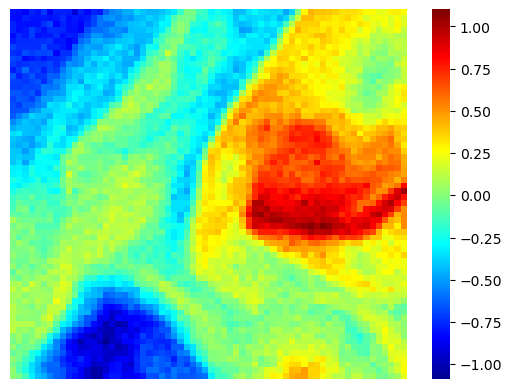

In [9]:
plotting.show_image(sst_100)

## $\Delta T$

In [10]:
T90 = np.percentile(sst_100, 90)
T10 = np.percentile(sst_100, 10)
T90-T10

1.133066177368164